In [1]:
#importo e librerie che mi serviranno
import pymongo
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns

URI = "mongodb://127.0.0.1:27017/?readPreference=primary&ssl=false"
client = pymongo.MongoClient(URI)
db = client['movie_dataset']



# Preparazione dei dati

In [2]:
#attori  con più di 8 ruoli che hanno eseguito nella loro carriera
df= pd.DataFrame( db.people.aggregate([{"$match" : {"jobs.8":{"$exists" : True}}}, {'$project': {'name': 1, 'gender': 1}
    }]))
df.head()

,_id,name,gender
0,15111,Jean-Claude Van Damme,2
1,14639,Mel Brooks,2
2,138,Quentin Tarantino,2
3,776,Eddie Murphy,2
4,1032,Martin Scorsese,2


In [3]:
#attori  con solo 2 ruoli  nella loro carriera
dfless= pd.DataFrame( db.people.aggregate([{ '$match': {'jobs': {'$size': 2}}},{'$project': {'name': 1, 'gender': 1}
    }]))
dfless.head()

,_id,name,gender
0,12899,Jim Varney,2
1,12900,Wallace Shawn,2
2,58563,David Alan Grier,2
3,8851,Whitney Houston,1
4,9780,Angela Bassett,1


In [4]:
#lista dei film
df_film = pd.DataFrame(db.metadata.find({}, {'_id':1, 'vote_average':1 , 'vote_count':1 }))
#dfn = df_film.loc[df_film['vote_count'] >= num_votazioni]    


In [5]:
df_film.shape

(45433, 3)

In [6]:
#dfn.shape

In [7]:
#rinomino la colonna _id in movie_id
df_film =  df_film.rename(columns = {'_id' : 'movie_id'})

In [8]:
#Lista crew
#prendo dalla collection crew l' id della persona del film e il ruolo svolto
df_crew = pd.DataFrame(db.crew.find({}, {'person_id':1, 'movie_id':1,'_id':0,'department':1})).astype({'movie_id': 'int32','person_id': 'int32'})

df_crew

,department,person_id,movie_id
0,Directing,7879,862
1,Writing,12891,862
2,Writing,7,862
3,Writing,12892,862
4,Writing,12893,862
...,...,...,...
464309,Sound,549356,67758
464310,Camera,58818,67758
464311,Directing,1085341,227506
464312,Production,1195656,227506


In [9]:
df_crew.dtypes

department    object
person_id      int32
movie_id       int32
dtype: object

In [10]:
#rinomino l' id delle persone da person_id a _id
df_crew =  df_crew.rename(columns = {'person_id' : '_id'})
df_crew.head()


,department,_id,movie_id
0,Directing,7879,862
1,Writing,12891,862
2,Writing,7,862
3,Writing,12892,862
4,Writing,12893,862


In [11]:
#Lista cast
#prendo dalla collection cast l' id della persona del film e come ruolo svolto metto attore, mi servirà quando andrò a fare la concat
df_cast = pd.DataFrame(db.cast.find({}, {'person_id':1, 'movie_id':1,'_id':0})).astype({'movie_id': 'int32','person_id': 'int32'})

df_cast['department'] = "Actor"
df_cast.head()

,person_id,movie_id,department
0,31,862,Actor
1,12898,862,Actor
2,7167,862,Actor
3,12899,862,Actor
4,12900,862,Actor


In [12]:
#rinomino l' id delle persone da person_id a _id
df_cast =  df_cast.rename(columns = {'person_id' : '_id'})

In [13]:
#concateno i due dataframe così ho tutti i ruoli che una persona ha svolto
df_crew = pd.concat([df_crew,df_cast],ignore_index=True)
df_crew

,department,_id,movie_id
0,Directing,7879,862
1,Writing,12891,862
2,Writing,7,862
3,Writing,12892,862
4,Writing,12893,862
...,...,...,...
1026783,Actor,544742,227506
1026784,Actor,1090923,227506
1026785,Actor,1136422,227506
1026786,Actor,1261758,227506


In [14]:
#join tra il dataframe contenente le persone che hanno svolto più ruoli e df_crew che contiene i vari ruoli eseguiti e il movie_id
df_firstmerge = pd.merge(df, df_crew, on='_id')
df_firstmerge.head(5)

,_id,name,gender,department,movie_id
0,15111,Jean-Claude Van Damme,2,Writing,9103
1,15111,Jean-Claude Van Damme,2,Directing,9103
2,15111,Jean-Claude Van Damme,2,Production,10366
3,15111,Jean-Claude Van Damme,2,Writing,9594
4,15111,Jean-Claude Van Damme,2,Production,9594


In [15]:
#data_it=df_firstmerge[df_firstmerge['department'] == 'Actor']
#data_it
#chi ha da 8 in su ruoli non ha mai fatto l' attore

In [16]:
#persone che hanno fatto solo 2 ruoli
df_lessmerge = pd.merge(dfless, df_crew, on='_id')
df_lessmerge

,_id,name,gender,department,movie_id
0,12899,Jim Varney,2,Crew,10865
1,12899,Jim Varney,2,Actor,862
2,12899,Jim Varney,2,Actor,11041
3,12899,Jim Varney,2,Actor,32302
4,12899,Jim Varney,2,Actor,863
...,...,...,...,...,...
158251,1599742,Hillary Wallace,0,Costume & Make-Up,390959
158252,1471628,Sam Resnick,0,Writing,30840
158253,1471628,Sam Resnick,0,Writing,30840
158254,1182809,Hamid Nematollah,0,Directing,439050


In [17]:
#capire quale raw mi dava problemi perché non rieco a fare join con la collezione metadata
#for i in range(df2.shape[0]):
  #  try:
     #   df2.movie_id[i] = int(df2.movie_id[i])
    
   # except ValueError:
     #  print("String is not Numaric: ", i )

In [18]:
#converto i vari id del dataframe da oggetti a int
df_film.movie_id = df_film.movie_id.astype(str).astype(int)

In [19]:
df_film.dtypes

movie_id          int32
vote_average    float64
vote_count      float64
dtype: object

In [20]:
#faccio il join tra il dataframe contenente le varie persone che hanno svolto da 8 ruoli in su, con i film da loro svolti
df_secondmerge = pd.merge(df_firstmerge, df_film, on='movie_id')


In [21]:
df_secondmerge.head()

,_id,name,gender,department,movie_id,vote_average,vote_count
0,15111,Jean-Claude Van Damme,2,Writing,9103,5.3,126.0
1,15111,Jean-Claude Van Damme,2,Directing,9103,5.3,126.0
2,15111,Jean-Claude Van Damme,2,Actor,9103,5.3,126.0
3,15111,Jean-Claude Van Damme,2,Production,10366,4.2,138.0
4,15111,Jean-Claude Van Damme,2,Actor,10366,4.2,138.0


In [22]:
#raggruppo e calcolo la votazione media
df_H1 = df_secondmerge.groupby("_id").agg({'vote_average':'mean'})


In [23]:
df_H1.reset_index(inplace=True)
df_H1

,_id,vote_average
0,1,6.706173
1,7,7.380000
2,8,7.460000
3,40,6.327273
4,42,6.727778
...,...,...
167,1434042,6.900000
168,1447503,6.591304
169,1447878,0.000000
170,1447879,0.000000


In [24]:
len(df_H1._id.unique())

172

In [25]:
#applico lo stesso procedimento per le persone che hanno svolto solo due ruoli
df_less_secondmerge = pd.merge(df_lessmerge, df_film, on='movie_id')
df_less_secondmerge.head()

,_id,name,gender,department,movie_id,vote_average,vote_count
0,12899,Jim Varney,2,Crew,10865,6.7,1257.0
1,12899,Jim Varney,2,Actor,10865,6.7,1257.0
2,16896,James Garner,2,Actor,10865,6.7,1257.0
3,1749,Leonard Nimoy,2,Actor,10865,6.7,1257.0
4,52300,Claudia Christian,1,Actor,10865,6.7,1257.0


In [26]:
#data_=df_less_secondmerge[df_less_secondmerge['name'] == 'Whitney Houston']
#data_

In [27]:
df_H2 = df_less_secondmerge.groupby("_id").agg({'vote_average':'mean'})
df_H2.reset_index(inplace=True)
df_H2

,_id,vote_average
0,2,6.166667
1,3,6.344828
2,9,7.450000
3,14,5.783333
4,22,4.814286
...,...,...
34303,1905685,4.600000
34304,1905689,4.600000
34305,1906586,0.000000
34306,1906602,7.500000


In [28]:
df_H2 = df_H2.loc[df_H2['vote_average'] >= 8]
df_H1 = df_H1.loc[df_H1['vote_average'] >= 7.5]

In [29]:
df_H1.describe()

,_id,vote_average
count,3.000000,3.000000
mean,42196.333333,7.645573
std,58280.954353,0.127612
min,4385.000000,7.568000
25%,8637.500000,7.571931
50%,12890.000000,7.575862
75%,61102.000000,7.684360
max,109314.000000,7.792857


In [31]:
df_H2.describe()

,_id,vote_average
count,4.080000e+02,408.000000
mean,1.096391e+06,8.442857
std,5.308493e+05,0.592877
min,4.640000e+02,8.000000
25%,9.327555e+05,8.000000
50%,1.210908e+06,8.200000
75%,1.492572e+06,8.608333
max,1.889095e+06,10.000000


# Grafici

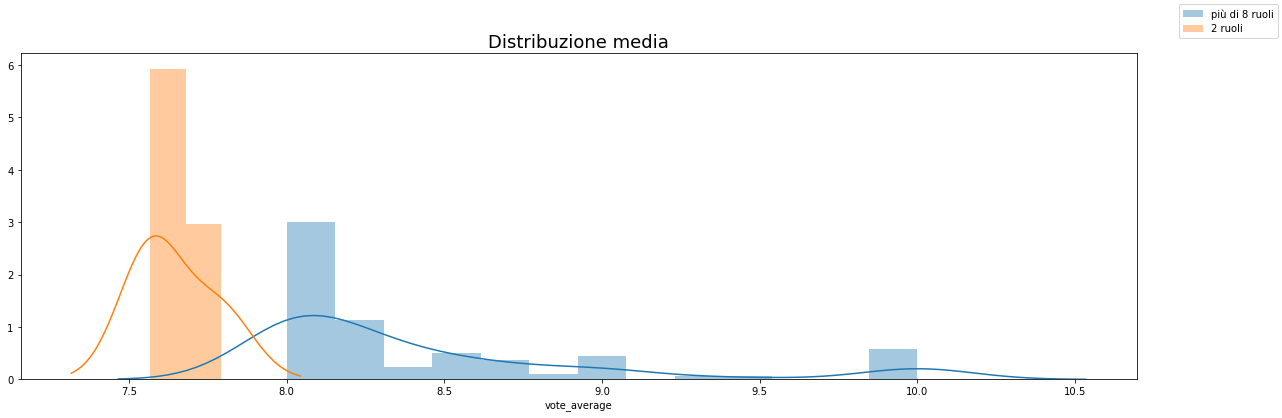

In [32]:
#analizzo la distribuzione di voti nei due casi analizzati
fig = plt.figure(figsize=(20,6))
sns.distplot(df_H2['vote_average'])
sns.distplot(df_H1['vote_average'])
plt.title('Distribuzione media', fontsize=18)
fig.legend(labels=['più di 8 ruoli', '2 ruoli'])

In [ ]:
#possiamo notare che effettivamente chi ha svolto più ruoli a partecipato a film con votazione più alta